In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil



tf.get_logger().setLevel('ERROR')

2.8.0


## Reading and preparing the dataset

In [2]:
data_columns = ["target", "tweet", "username"]
data_encoding = "ISO-8859-1"
data=pd.read_csv('./TwitterDataset.csv',encoding = data_encoding, usecols=data_columns)

tweets = data.iloc[:, 1]
labels = data.iloc[:, 0]

print(tweets.head())
print(data['target'].value_counts())

0    the real reason why you're sad? you're attache...
1        my biggest problem is overthinking everything
2    the worst sadness is the sadness you've taught...
3    i cannot make you understand. i cannot make an...
4    i don't think anyone really understands how ti...
Name: tweet, dtype: object
0    4695
1    3440
Name: target, dtype: int64


In [3]:
data.head(5)

,target,tweet,username
0,1,the real reason why you're sad? you're attache...,depressingmsgs
1,1,my biggest problem is overthinking everything,depressingmsgs
2,1,the worst sadness is the sadness you've taught...,depressingmsgs
3,1,i cannot make you understand. i cannot make an...,depressingmsgs
4,1,i don't think anyone really understands how ti...,depressingmsgs


In [4]:
def preprocess(tweet):
    username = "@\S+"
    new_tweet = re.sub(username, ' ',tweet) # Remove @tags
    
    new_tweet = new_tweet.lower() # Smart lowercase
    
    new_tweet = re.sub(r'\d+', ' ', new_tweet) # Remove numbers
    
    text_noise = "https?:\S+|http?:\S|[^A-Za-z0-9]+" 
    new_tweet = re.sub(text_noise, ' ', new_tweet) # Remove links
    
    new_tweet = new_tweet.translate(new_tweet.maketrans('','',string.punctuation)) # Remove Punctuation
    
    # new_tweet = new_tweet.strip() # Remove white spaces
    
    # new_tweet = word_tokenize(new_tweet) # Tokenize into words
    
    # new_tweet = ' '.join([word for word in new_tweet if word.isalpha()]) # Remove non alphabetic tokens
    
    # stop_words = set(stopwords.words('english'))
    # new_tweet = ' '.join([word for word in new_tweet.split() if not word in stop_words]) # Filter out stop words
    
    # lemmatizer = WordNetLemmatizer()
    # new_tweet = ' '.join([lemmatizer.lemmatize(word,"v") for word in new_tweet.split()]) # Word Lemmatization
    
    return new_tweet

In [5]:
import re
import string
tweets = tweets.apply(preprocess)
display(tweets.head())

0    the real reason why you re sad you re attached...
1        my biggest problem is overthinking everything
2    the worst sadness is the sadness you ve taught...
3    i cannot make you understand i cannot make any...
4    i don t think anyone really understands how ti...
Name: tweet, dtype: object

In [6]:
data.head(5)

,target,tweet,username
0,1,the real reason why you're sad? you're attache...,depressingmsgs
1,1,my biggest problem is overthinking everything,depressingmsgs
2,1,the worst sadness is the sadness you've taught...,depressingmsgs
3,1,i cannot make you understand. i cannot make an...,depressingmsgs
4,1,i don't think anyone really understands how ti...,depressingmsgs


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['tweet'],data['target'], stratify=data['target'])

X_train.head(4)

5627    Most people ignore opportunities because they ...
4692    Macaroni and Feed~   Finishing my post-work sn...
5814    Uhhhhh how do I fix pls ð¥º  https://t.co/iTe...
6780    Temper your words with a consciousness of empa...
Name: tweet, dtype: object

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow-text
import tensorflow_text as text

In [9]:
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [10]:
bert_preprocess_model = hub.KerasLayer('bert_en_uncased_preprocess_3')

In [12]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess_model(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
##


# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train , epochs=10, batch_size = 32)#, validation_data=0.2

Epoch 1/10
191/191 [==============================] - 60s 314ms/step - loss: 0.3821 - accuracy: 0.8428
Epoch 2/10
191/191 [==============================] - 61s 318ms/step - loss: 0.3602 - accuracy: 0.8528
Epoch 3/10
191/191 [==============================] - 61s 319ms/step - loss: 0.3441 - accuracy: 0.8620
Epoch 4/10
191/191 [==============================] - 61s 321ms/step - loss: 0.3396 - accuracy: 0.8656
Epoch 5/10
191/191 [==============================] - 61s 322ms/step - loss: 0.3250 - accuracy: 0.8715
Epoch 6/10
191/191 [==============================] - 61s 320ms/step - loss: 0.3179 - accuracy: 0.8756
Epoch 7/10
191/191 [==============================] - 62s 323ms/step - loss: 0.3158 - accuracy: 0.8767
Epoch 8/10
191/191 [==============================] - 61s 322ms/step - loss: 0.3081 - accuracy: 0.8812
Epoch 9/10
191/191 [==============================] - 62s 324ms/step - loss: 0.3049 - accuracy: 0.8818
Epoch 10/10
191/191 [==============================] - 62s 324ms/step - l

In [18]:
model.evaluate(X_test, y_test)

64/64 [==============================] - 21s 316ms/step - loss: 0.2943 - accuracy: 0.8845


[0.29429715871810913, 0.8844640851020813]

In [19]:
display(model.evaluate(X_train,y_train), 'train')


191/191 [==============================] - 61s 315ms/step - loss: 0.2808 - accuracy: 0.8946


[0.2807525396347046, 0.894607424736023]

'train'

In [20]:
from sklearn.metrics import classification_report

predictions = model.predict(X_train)
predictions = [1 if p >= 0.5 else 0 for p in predictions]

print(classification_report(y_train, predictions, target_names=['not depressed', 'depressed']))

               precision    recall  f1-score   support

not depressed       0.90      0.92      0.91      3521
    depressed       0.88      0.86      0.87      2580

     accuracy                           0.89      6101
    macro avg       0.89      0.89      0.89      6101
 weighted avg       0.89      0.89      0.89      6101



In [21]:
predictions = model.predict(X_test)
predictions = [1 if p >= 0.5 else 0 for p in predictions]

print(classification_report(y_test, predictions, target_names=['not depressed', 'depressed']))

               precision    recall  f1-score   support

not depressed       0.90      0.90      0.90      1174
    depressed       0.87      0.86      0.86       860

     accuracy                           0.88      2034
    macro avg       0.88      0.88      0.88      2034
 weighted avg       0.88      0.88      0.88      2034



In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
conf_mat = confusion_matrix(y_test, predictions)

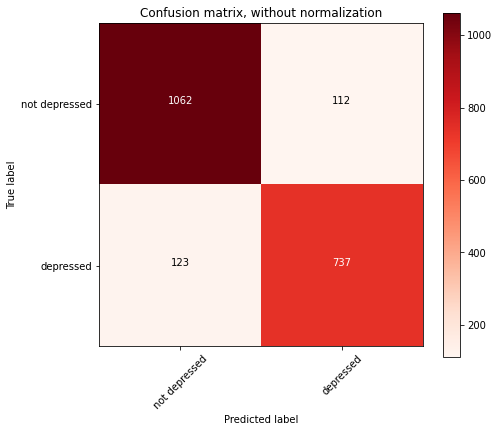

In [25]:
np.set_printoptions(precision=2)
classes = ['not depressed', 'depressed']
fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix, without normalization')
#fig1.savefig('../cm_wo_norm.jpg')
plt.show()

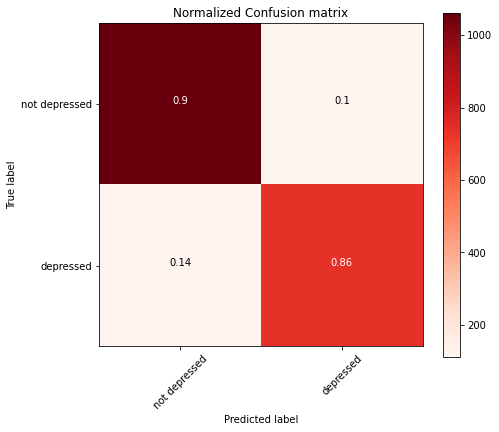

In [26]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [27]:
model_json = model.to_json()
with open('Bert_89.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('Bert89.h5')